<a href="https://colab.research.google.com/github/GiuliaCN/MAC0417/blob/main/ep3_segmetacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EP3.1 - MAC0417/5768 - Visão e Processamento de Imagens

Professor: Roberto Marcondes

Alunos:

*   Carlos Reis NºUSP 11295741
*   Daniel Silva Lopes da Costa N°USP 11302720
*   Giulia Cunha De Nardi N°10692203

Pasta no Drive: https://drive.google.com/drive/folders/1UCvz5sp8_lax59cgArrOyZSArcTVpvfI?usp=sharing


Github: https://github.com/GiuliaCN/MAC0417




# 1 - Introdução

Segmentação é ao processo de partir uma imagem em várias regiões  ou objetos, com o objetivo de simplificar  a representação de uma imagem para facilitar a sua análise. Essa técnica de imagens é tipicamente usada para localizar objetos e formas.

Nesse relatório será realizado a sementação manual, segmentação automática e com base nisso vamos determinar a a feret box, região da imagem onde o objeto se encontra. Além disso vamos fazer um análise dos métodos para valdiar sua eficiência.

# 2- Objetivo

Fazer segmentação das imagens para distinguir o objeto do fundo, gerando uma imagem binária, onde o objeto de interesse é branco e o o fundo preto. Inicialemente será realizada a segmentação manual de 15% das imagens de cada classe usando o software gimp. Em seguida vamos implementar um algoritmo que realize essa segmentação de maneira automática. 



#3 - Leitura dos dados

In [17]:
# Conectar-se ao Drive
from google.colab import drive

# https://docs.python.org/3/library/os.html
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches


# skimage.io para carregar as imagens
# https://scikit-image.org/docs/dev/api/skimage.io.html
from skimage import io
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.util import invert
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb



# https://pandas.pydata.org/
import pandas as pd
import numpy as np


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [72]:
os.chdir('/content/gdrive/My Drive/IME/3Semestre/Visao/eps/')

In [50]:
classes = os.listdir('datasets/originalGrayDataset') #Lista de classes
datasets = os.listdir('datasets/augmentedDataset') #Lista de datasets

['logDataset',
 'expDataset',
 'meanDataset',
 'sumDataset',
 'grayDataset',
 'originalDataset']

In [5]:
df = pd.read_csv('datasets/Metadados.csv')

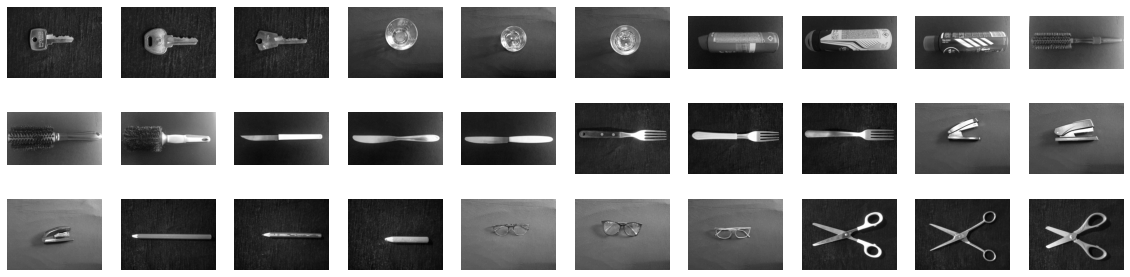

In [6]:
'''
Visualização das imagens base
'''

imgs = io.imread_collection("datasets/originalGrayDataset/*/*-*pdi1.jpg") # coloque a sua ext
n_colunas, n_linhas = 10, 3

fig, axs = plt.subplots(3, 10, figsize=(20, 5))
num_fotos = n_colunas * n_linhas
for e, objeto in enumerate(imgs[:num_fotos]):
    l, c = (e // n_colunas, e % n_colunas)
    axs[l, c].imshow(objeto, cmap=plt.cm.gray)
    axs[l, c].axis('off')
plt.show()

# 4 - Segmentação

### 4.1 - Segmentação automática

Foi usado o softaware gimp para destacar o obejto do seu fundo de maneira manual. Foi um processo bem demorado e trabalhoso que explicitou a dificuldade em se gerar uma boa segmentação de um objeto.

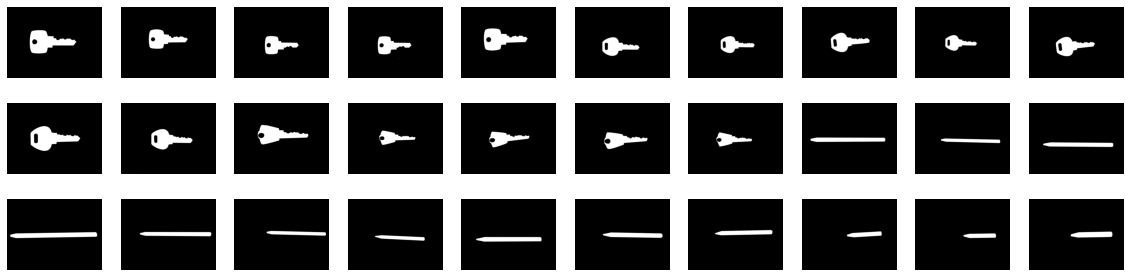

In [7]:
'''
Visualização dos resultados da segmentação automática
'''

imgs = io.imread_collection("datasets/segmentedManualDataset/*/*-*.jpg") # coloque a sua ext
n_colunas, n_linhas = 10, 3

fig, axs = plt.subplots(3, 10, figsize=(20, 5))
num_fotos = n_colunas * n_linhas
for e, objeto in enumerate(imgs[:num_fotos]):
    l, c = (e // n_colunas, e % n_colunas)
    axs[l, c].imshow(objeto, cmap=plt.cm.gray)
    axs[l, c].axis('off')
plt.show()

### 4.2 - Segmentação automática

Na segmentaçãoa automática testamos dois algortimos da biblioteca sckiti image. O algoritmo de Chan-Vese e de Otsu, mas o Chan-Vese estava muito lento e o Otsu forneceu resultados suficientemente bons. Esse algoritimo também foi discutido em classe, na palestra do Hugo sobre segmetação. Mas apenas o Otsu estva um pouco problemático nas imagens com fundo marron onde não havia muito contraste entre o objeto e o fundo, por conta disso também foi usada o método de detecção de bordas de Canny para elevar a eficiência do método. Com isso, chegamos no algoritmo abaixo.

In [ ]:
'''
Gerar imagens binárias, objeto branco e fundo preto
'''
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.morphology import binary_dilation
from scipy import ndimage as ndi
from skimage.util import invert

for classe in classes:
  imgs = io.imread_collection("datasets/originalGrayDataset/"+classe+"/*.jpg") # coloque a sua ext
  list_files = os.listdir('datasets/originalGrayDataset/'+classe)
  list_files.sort()
  i = 0
  for image in imgs:

    image = gaussian(image)
    ls = threshold_otsu(image)
    ls = 0.8 * ls
    li = 0.2 * ls

    edges = canny(image, sigma=1, low_threshold=li, high_threshold=ls)

    edges = binary_dilation(edges, square(5))
    fill = ndi.binary_fill_holes(edges)

    label_objects, nb_labels = ndi.label(fill)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > 20
    mask_sizes[0] = 0
    binary = mask_sizes[label_objects]
    
    binary = binary.astype('float32')

    # Imagens com fundo preto ficaram com as cores invertidas para reolver isso, testa-se se o canto é realmente preto 
    avalia = binary[0:20, 0:20]
    pontos = np.sum(avalia < 0.1) 
    if pontos < 300:
      binary = invert(binary)

    io.imsave("datasets/segmentedAutomaticDataset/"+classe+"/"+list_files[i], binary)
    i+=1


Algumas imagens ficaram bem problemáticas mas no geral a maioria dela foi possível distinguir a forma do objeto e as cores estão corretas.

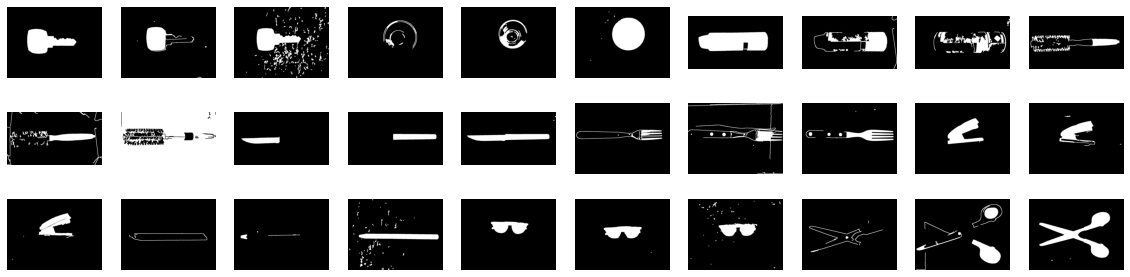

In [28]:
'''
Visualização de alguns objetos após a transformação
'''

imgs = io.imread_collection("datasets/segmentedAutomaticDataset/*/*-1*di1.jpg") # coloque a sua ext
n_colunas, n_linhas = 10, 3

fig, axs = plt.subplots(3, 10, figsize=(20, 5))
num_fotos = n_colunas * n_linhas
for e, objeto in enumerate(imgs[:num_fotos]):
    l, c = (e // n_colunas, e % n_colunas)
    axs[l, c].imshow(objeto, cmap=plt.cm.gray)
    axs[l, c].axis('off')
plt.show()

### 4.3 - Feret box

Esse técnica serve para deterninar a posição do objeto na imagem facilitando assim o treinamento de algoritmos de visualização. Para tanto foi usado a ferramenta label_image da biblioteca sickit image, a qual divide a imagem nas mariores regiões contínuas em branco, com essa informação eu selecino a maior região encontrada.

In [62]:
def feret_box(image):
  cleared = clear_border(image)
  label_image = label(cleared)
  image_label_overlay = label2rgb(label_image, image=image, bg_label=0)


  if regionprops(label_image):
      max_area = 0
      for region in regionprops(label_image):
        if region.area >= max_area:
          minr, minc, maxr, maxc = region.bbox
          max_area = (maxc - minc) * (maxr - minr)
          regionMax = region
  else: #Se não encontrar nenhuma região, faz o box da imagem toda
    minr, minc, maxr, maxc = 0, 0, image.shape[0], image.shape[1]

  return minr, minc, maxr, maxc

Inicialemente testamos o método para um única imagem. Foi analisada a imagem em tons de cinza e os dois tresholds. De imediato é possível perceber a importância de se achar o ground-truth para realmente poder encontrar o objeto, o que não aconteceu no cado da imagem original. 

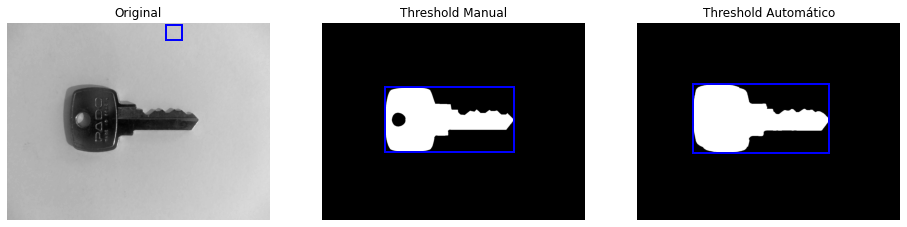

In [69]:
'''
Teste para caso iniciais 
'''

image1 = io.imread("datasets/originalGrayDataset/chave/chave-1bdi1.jpg")
image2 = io.imread("datasets/segmentedManualDataset/chave/chave-1bdi1.jpg")
image3 = io.imread("datasets/segmentedAutomaticDataset/chave/chave-1bdi1.jpg")
imgs = [image1, image2, image3]

fig, axes = plt.subplots(ncols=3, figsize=(16, 6))

ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])
titles = ['Original', 'Threshold Manual', 'Threshold Automático']

for i in range(3):
  minr, minc, maxr, maxc = feret_box(imgs[i])
  ax[i].imshow(imgs[i], cmap=plt.cm.gray)
  ax[i].set_title(titles[i])
  ax[i].axis('off')
  rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='blue', linewidth=2)
  ax[i].add_patch(rect)

plt.show()
        


Em seguida, vamos encontrar esse regiãod e interesse para cada imagem do dataset segmentado e para todas a imagens no dataset augmented realizar o corte na região encontrada, para assim, gerar um banco de imagens apenas comas regiões de interesse onde está o objeto.

In [ ]:
'''
Criação da dataset com as imagens cortadas
'''

for classe in classes:
  imgs = io.imread_collection("datasets/segmentedAutomaticDataset/"+classe+"/*.jpg") # coloque a sua ext
  list_files = os.listdir('datasets/segmentedAutomaticDataset/'+classe)
  list_files.sort()
  i = 0
  for image in imgs:
    minr, minc, maxr, maxc = feret_box(image):
    #Realiza o corte para todas a imagens que estão nos outros datasets de treinamento
    for dataset in datasets:
      imagem_augemented = io.imread("datasets/augmentedDataset/"+dataset+"/"+classe+"/"+list_files[i]) # coloque a sua ext
      imagem = imagem_augemented[minr:maxr,minc:maxc]
      io.imsave("datasets/augmentedSegmentedDataset/"+dataset+"/"+classe+"/"+list_files[i], imagem)
    i+=1

Pela vizalização é possível perceber que algumas imagens tiveram problemas, com a região errada selecionada, mas no geral tiver um resultado positivo.

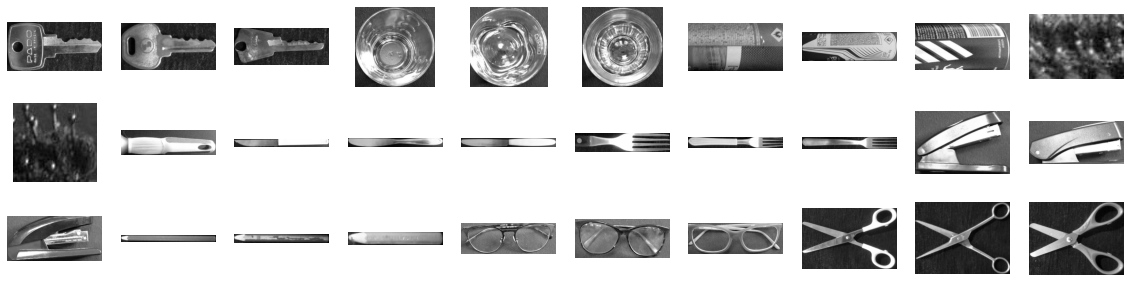

In [75]:
'''
Visualização de alguns objetos após a transformação
'''

imgs = io.imread_collection("datasets/augmentedSegmentedDataset/grayDataset/*/*-*pdi1.jpg") # coloque a sua ext
n_colunas, n_linhas = 10, 3

fig, axs = plt.subplots(3, 10, figsize=(20, 5))
num_fotos = n_colunas * n_linhas
for e, objeto in enumerate(imgs[:num_fotos]):
    l, c = (e // n_colunas, e % n_colunas)
    axs[l, c].imshow(objeto, cmap=plt.cm.gray)
    axs[l, c].axis('off')
plt.show()

### 4.4 - Avaliação Segmentação

Para avaliar a segmentação automática usamos o métodos Intersection-Over-Union, ele pega a área da intersecção entre objeto segmentado manualmente e o mesmo objeto segmentado de maneira atomática e dividie pela união das duas áreas.

$$IoU = \frac{AreaOverlap}{AreaUnion}$$

In [ ]:
acuracia = []
acuracia_fundo_preto = []
acuracia_fundo_branco = []
acuracia_fundo_cinza = []
cla = ['chave','lapis']
for classe in cla:
  imgs = io.imread_collection("datasets/segmentedManualDataset/"+classe+"/*.jpg") # coloque a sua ext
  list_files = os.listdir('datasets/segmentedManualDataset/'+classe)
  list_files.sort()
  i = 0
  acuClasse = 0
  for image in imgs:
    image_seg = imgs = io.imread("datasets/segmentedAutomaticDataset/"+classe+"/"+list_files[i])
    image = image.astype("uint16")
    image_seg = image_seg.astype("uint16")
    soma = image + image_seg
    intercecao = np.sum(soma>490)
    uniao = np.sum(soma>245)
    a = intercecao/uniao
    acuracia.append(a)
    acuClasse += a
    if list_files[i][7]=='b':
      acuracia_fundo_branco.append(a)
    elif list_files[i][7]=='p':
      acuracia_fundo_preto.append(a)
    elif list_files[i][7]=='m':
      acuracia_fundo_cinza.append(a)
    i+=1;
  acuraciaClasse = acuClasse/(i)
  print("A acurácia média classe " + classe + " foi de ", acuraciaClasse)


A acurácia média classe chave foi de  0.6714119095438408
A acurácia média classe lapis foi de  0.5195026799473685


Com a comparação da acurácia por diferentes fundos percebe-se que os melhores resultados foram encontrados em imagens com fundo preto, mas as com fundo branco tabém funcionaram bem, as com fundo cinza foram as mais problemáticas, muito provavelmente pois não tem um ponto de conte muito claro no histograma o que leva a erro do algoritmo de otsu.

Text(0.5, 1.0, 'Acuracia segmentação por fundo')

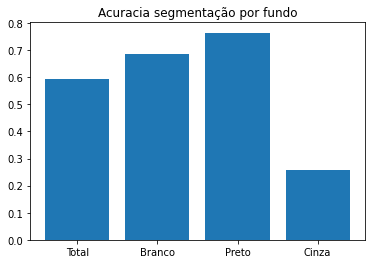

In [ ]:
m_total = np.sum(acuracia)/len(acuracia)
m_fb = np.sum(acuracia_fundo_branco)/len(acuracia_fundo_branco)
m_fp = np.sum(acuracia_fundo_preto)/len(acuracia_fundo_preto)
m_fc = np.sum(acuracia_fundo_cinza)/len(acuracia_fundo_cinza)

m_acuracia = [m_total, m_fb, m_fp, m_fc]
nomes = ["Total", "Branco", "Preto", "Cinza"]

plt.bar(nomes, m_acuracia)
plt.title("Acuracia segmentação por fundo")



### 5 - Conclusões

Foi evidente a dificuldade para se fazer o treshold manual, o grupo usou o software gimp e foi uma das partes mais demoradas do exércício, além disso também foi possível notar que a segmetnação automática funcionou muito bem em fundo escuro, preto, onde havia mais contraste e o algoritmo conseguiu selecionar melhor o objeto.

O resultado final da segmentação foi o dataset augmentedSegmentedDataset que possui um recorte da imagem onde o algortimo detectou que seeria o objeto. O próximo passo é usar esse dataset para extrair características da classe e montar um classificador para reconhecer as imagens.